In [1]:
import pickle
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Dense, Input, add, dot, concatenate, Permute,LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import messagebox


In [2]:

# Constants
BATCH_SIZE = 32
EPOCHS = 150

# Load data
with open("train_qa.txt", "rb")as fp:
    train_data = pickle.load(fp)

with open("test_qa.txt", "rb")as fp:
    test_data = pickle.load(fp)

# Prepare vocabulary
vocab = set()
all_data = test_data + train_data
for story,question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
vocab.add('yes')
vocab.add('no')
vocab_len = len(vocab)+1

# Find maximum story and question lengths
max_story_len=max([len(data[0])for data in all_data])
max_ques_len=max([len(data[1])for data in all_data])

# Tokenize the data
tokenizer =Tokenizer(filters = [])
tokenizer.fit_on_texts(vocab)

# Vectorize the stories
def vectorize_stories(data, word_index=tokenizer.word_index, 
                      max_story_len=max_story_len, max_ques_len=max_ques_len):
    story_sequences = []
    question_sequences = []
    answer_sequences = []

    for story, query, answer in data:
        x = [word_index.get(word.lower(), 0) for word in story]
        xq = [word_index.get(word.lower(), 0) for word in query]
        
        if answer:
            y = np.zeros(len(word_index) + 1)
            y[word_index[answer]] = 1
        else:
            y = np.zeros(len(word_index) + 1)
        
        story_sequences.append(x)
        question_sequences.append(xq)
        answer_sequences.append(y)

    return (
        pad_sequences(story_sequences, maxlen=max_story_len),
        pad_sequences(question_sequences, maxlen=max_ques_len),
        np.array(answer_sequences)
    )


Epoch 1/150
313/313 [==============================] - 23s 43ms/step - loss: 0.8891 - accuracy: 0.4962 - val_loss: 0.6982 - val_accuracy: 0.5030
Epoch 2/150
313/313 [==============================] - 12s 37ms/step - loss: 0.7062 - accuracy: 0.4958 - val_loss: 0.6956 - val_accuracy: 0.4970
Epoch 3/150
313/313 [==============================] - 12s 38ms/step - loss: 0.6976 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.4930
Epoch 4/150
313/313 [==============================] - 7s 22ms/step - loss: 0.6963 - accuracy: 0.4943 - val_loss: 0.6944 - val_accuracy: 0.4970
Epoch 5/150
313/313 [==============================] - 7s 21ms/step - loss: 0.6962 - accuracy: 0.4920 - val_loss: 0.6946 - val_accuracy: 0.4970
Epoch 6/150
313/313 [==============================] - 6s 20ms/step - loss: 0.6950 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 7/150
313/313 [==============================] - 4s 14ms/step - loss: 0.6956 - accuracy: 0.5005 - val_loss: 0.6931 - val_accura

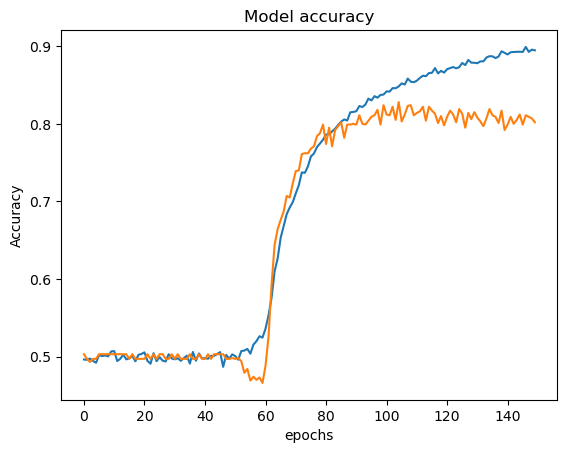

In [3]:

# Prepare training and testing data
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

# Define the model architecture
input_sequence = Input((max_story_len,))
question = Input((max_ques_len,))

input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len, output_dim=64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len, output_dim=max_ques_len))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len, output_dim=64, input_length=max_ques_len))
question_encoder.add(Dropout(0.3))

input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

answer = concatenate([response, question_encoded])

answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)
answer = Activation('softmax')(answer)

model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([inputs_train, queries_train], answers_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=([inputs_test, queries_test], answers_test))

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('Accuracy')
plt.xlabel("epochs")
plt.show()


In [5]:

# Save the model
model.save("chatbot_model")

# Load the model
model.load_weights("chatbot_model")

# GUI
window = tk.Tk()
window.title("Chatbot GUI")

result_label = tk.Label(window, text="Predicted Answer:", font=("Helvetica", 14))
result_label.pack(pady=10)

probability_label = tk.Label(window, text="Probability of Certainty:", font=("Helvetica", 14))
probability_label.pack(pady=10)

placeholder_text_story = "Enter the story..."
story_entry = tk.Entry(window, width=50, font=("Helvetica", 12))
story_entry.pack(pady=5)
story_entry.insert(tk.END, placeholder_text_story)

placeholder_text_question = "Enter the question..."
question_entry = tk.Entry(window, width=50, font=("Helvetica", 12))
question_entry.pack(pady=5)
question_entry.insert(tk.END, placeholder_text_question)

def clear_entry_field(event, entry, placeholder_text):
    if entry.get() == placeholder_text:
        entry.delete(0, tk.END)

def predict_answer():
    story_text = story_entry.get()
    question_text = question_entry.get()
    
    if story_text == "" or story_text == placeholder_text_story or question_text == "" or question_text == placeholder_text_question:
        messagebox.showerror("Error", "Please enter the story and question.")
        return
    
    story = story_text.split()
    question = question_text.split()
    mydata = [(story, question, "")]
    my_story, my_ques, _ = vectorize_stories(mydata)
    
    for word in story + question:
        if word.lower() not in tokenizer.word_index:
            messagebox.showerror("Error", "Word not found in vocabulary.")
            return
    
    pred_results = model.predict(([my_story, my_ques]))
    val_max = np.argmax(pred_results[0])
    
    for key, val in tokenizer.word_index.items():
        if val == val_max:
            predicted_answer = key
            break
    
    probability = pred_results[0][val_max]
    
    result_label.config(text="Predicted Answer: " + predicted_answer)
    probability_label.config(text="Probability of Certainty: {:.2f}".format(probability))

predict_button = tk.Button(window, text="Predict", command=predict_answer, font=("Helvetica", 14), bg="#4caf50", fg="white", relief=tk.RAISED, bd=0)
predict_button.pack(pady=10)

window.mainloop()

INFO:tensorflow:Assets written to: chatbot_model\assets


INFO:tensorflow:Assets written to: chatbot_model\assets


1/1 [==============================] - 0s 23ms/step


In [13]:
# GUI
window = tk.Tk()
window.title("Chatbot GUI")
window.configure(bg='lightblue')

def clear_entry(event, entry, default_text):
    if entry.get() == default_text:
        entry.delete(0, tk.END)

# Create entry fields for the story and question
story_entry = tk.Entry(window, width=80, font=("Helvetica", 12), bg='white')
default_story_text = "Enter the story here..."
story_entry.insert(tk.END, default_story_text)
story_entry.bind("<FocusIn>", lambda event: clear_entry(event, story_entry, default_story_text))
story_entry.pack(pady=10)

question_entry = tk.Entry(window, width=80, font=("Helvetica", 12), bg='white')
default_question_text = "Enter the question here..."
question_entry.insert(tk.END, default_question_text)
question_entry.bind("<FocusIn>", lambda event: clear_entry(event, question_entry, default_question_text))
question_entry.pack(pady=10)

# Create a button to send the story and question
def send_message():
    story_text = story_entry.get()
    question_text = question_entry.get()
    if story_text != "" and question_text != "":
        # Predict the chatbot's response
        story = story_text.split()
        question = question_text.split()
        mydata = [(story, question, "")]
        my_story, my_ques, _ = vectorize_stories(mydata)
        pred_results = model.predict(([my_story, my_ques]))
        val_max = np.argmax(pred_results[0])
        for key, val in tokenizer.word_index.items():
            if val == val_max:
                predicted_answer = key
                break
        chat_window.insert(tk.END, "Chatbot: " + predicted_answer)

send_button = tk.Button(window, text="Send", command=send_message, font=("Helvetica", 14), bg="#4caf50", fg="white", relief=tk.RAISED, bd=0)
send_button.pack(pady=10)

# Create a chat window to display the chatbot's responses
chat_window = tk.Listbox(window, width=80, height=8, font=("Helvetica", 12), bg='white')
chat_window.pack(pady=10)

window.mainloop()

1/1 [==============================] - 0s 24ms/step
